In [1]:
# sklearn Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# sklearn Utils
from sklearn.base import BaseEstimator
from sklearn.base import clone
from sklearn.model_selection import train_test_split

import numpy as np
from numpy.random import default_rng
import random

np.random.seed(42)

from matplotlib.legend_handler import HandlerTuple
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

from probml_utils import active_learn_utils as alu

try:
    import modAL
except ModuleNotFoundError:
    %pip install -qq modAL
    import modAL


from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import entropy_sampling
from modAL.uncertainty import margin_sampling
from modAL.disagreement import max_std_sampling

from modAL.models import ActiveLearner
from modAL.utils.data import modALinput
from modAL.models import Committee

from typing import Callable
from typing import Tuple
from typing import Optional
import warnings
from typing import List

from functools import reduce
import operator

In [2]:
# Default RC parms for grid and line plot
p = plt.rcParams

# Grid Setting
p["grid.color"] = "#999999"
p["grid.linestyle"] = "--"

# Markersize setting for scatter
if pml.is_latexify_enabled():
    p["lines.markersize"] = 3
    p["lines.markeredgewidth"] = 1
    p["lines.linewidth"] = 1.5
    p["grid.linewidth"] = 0.5
else:
    p["lines.markersize"] = 5
    p["lines.markeredgewidth"] = 1.5
    p["lines.linewidth"] = 2

In [3]:
def plot_data(
    sampling_dict: dict,
    n_queries: int,
    problem_type: str,
    latexify_dict: dict = {"fig_name": None, "legend_pos": "best"},
    grid_flag: bool = True,
) -> None:
    """
    Make accurracy/rmse vs # of query iteration plots

    Args:
    ----------
    sampling_dict :
        Dictionary with log of all the points queried along with
        other info

    n_queries :
        The number for iterations that were run for each sampling technique

    problem_type :
        Classification or Regression Problem

    latexify_dict :
        Options for latexified figures

    grid_flag:
        To toggle grids on graphs

    Returns:
    ----------
    None
    """

    # Initialize figure
    fig = plt.figure()
    ax = plt.gca()

    # Toggle Grid
    ax.grid(grid_flag)

    # Number of Iterations for x-axis labels
    x_axis = np.array([i for i in range(n_queries + 1)])

    for key, value in sampling_dict.items():

        # If not random sampling just plot the score
        if value["type"] != "random":
            plt.plot(x_axis, value["score"], label=key + " sampling", marker=value["marker"])
        # If random sampling query strat, plot random accuracies along with mean accuracy or rmse
        elif value["type"] == "random":
            # Choose any n random accuracy curves
            all_random_iter = len(value["score"]) - 1
            random_choice = np.random.choice(all_random_iter, size=value["disp_randoms"], replace=False)
            # Plot random curves
            for i in random_choice:
                scores = value["score"][i]
                plt.plot(
                    x_axis,
                    scores,
                    label=key + " samples",
                    marker=value["marker"],
                    color="blueviolet",
                    alpha=0.25,
                )
            # Plot mean accuracy curve
            plt.plot(
                x_axis,
                value["mean_score"],
                label=f"Mean of {key} sampling",
                marker=value["marker"],
                color="blueviolet",
            )

    sns.despine()
    plt.xticks([i for i in range(x_axis[0], x_axis[-1] + 1, 5)])
    plt.xlabel("Number of Points queried")

    # Remove Duplicates created due to Different Random Plots
    handles, labels = ax.get_legend_handles_labels()
    newLabels, newHandles = [], []
    for handle, label in zip(handles, labels):
        if label not in newLabels:
            newLabels.append(label)
            newHandles.append(handle)

    # Different axes labels based on problem type
    if problem_type == "Classification":
        plt.ylabel("Accuracy")
    else:
        plt.ylabel("RMSE")

    # Custom plotting options
    if pml.is_latexify_enabled() and latexify_dict["fig_name"]:
        pml.latexify(**latexify_dict["latexify_parms"])
        plt.legend(handles=newHandles, labels=newLabels, **latexify_dict["legend_params"])
        pml.savefig(latexify_dict["fig_name"])
    else:
        plt.legend(
            handles=newHandles,
            labels=newLabels,
            loc="upper right",
            bbox_to_anchor=(1.55, 1),
        )

    plt.show()

In [4]:
def compare_sampling(
    sampling_dict_data: dict,
    problem_type: str,
    n_queries: int,
    X_pool: np.ndarray,
    y_pool: np.ndarray,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    latexify_dict={"fig_name": None, "legend_pos": "best"},
) -> None:
    """
    Driver function to run uncertanity, QBC or random sampling approach

    Args:
    ----------
    sampling_dict_data :
        Dictionary with log of all the points queried along with
        other info

    problem_type :
        Classification or Regression Problem

    n_queries :
        The number for iteration to run for each sampling technique

    latexify_dict :
        Options for latexified figures

    X_pool:
        Features pool data

    y_pool:
        Labels pool data

    X_train:
        Features train data

    y_train:
        Labels train data

    X_test:
        Features test data

    y_train:
        Labels test data


    Returns:
    ----------
    None

    """

    # Loop over each uncertanity type
    for key, value in sampling_dict_data.items():

        # For uncertanity
        if value["type"] == "uncertanity":
            uncertanity_info_dict = alu.uncertainty_sampling(
                value["query_strat"],
                value["model"],
                key,
                n_queries,
                problem_type=problem_type,
                X_pool=X_pool,
                y_pool=y_pool,
                X_train=X_train,
                y_train=y_train,
                X_test=X_test,
                y_test=y_test,
            )
            value["score"] = uncertanity_info_dict["score"]
        # For uncertanity
        elif value["type"] == "qbc":
            qbc_info_dict = alu.qbc(
                value["query_strat"],
                value["model"],
                problem_type,
                n_queries,
                X_pool=X_pool,
                y_pool=y_pool,
                X_train=X_train,
                y_train=y_train,
                X_test=X_test,
                y_test=y_test,
            )
            value["score"] = qbc_info_dict["score"]
        # For Random
        else:
            for i in range(value["n_iter"]):
                uncertanity_info_dict = alu.uncertainty_sampling(
                    value["query_strat"],
                    value["model"],
                    key,
                    n_queries,
                    problem_type=problem_type,
                    X_pool=X_pool,
                    y_pool=y_pool,
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test,
                )
                value["score"].append(uncertanity_info_dict["score"])

            # Mean and std dev for errors for random sampling
            err_arr = np.array(sampling_dict_data[key]["score"])
            mean_err_arr = np.mean(err_arr, axis=0)
            stddev_err_arr = np.std(err_arr, axis=0)

            sampling_dict_data[key]["mean_score"] = mean_err_arr
            sampling_dict_data[key]["std_dev"] = stddev_err_arr

    # Plot the data
    plot_data(sampling_dict_data, n_queries, problem_type, latexify_dict)

### Comparison of uncertanity sampling and random sampling

In [5]:
# Get Data for classification
(
    _,
    _,
    _,
    _,
    _,
    _,
    X_train,
    X_pool,
    y_train,
    y_pool,
    X_test,
    y_test,
) = alu.make_data_class()

/home/nitish1295/.local/lib/python3.8/site-packages/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


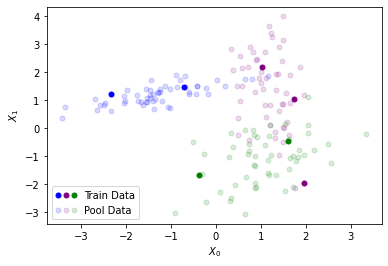

In [6]:
# Display data plot

pml.latexify(width_scale_factor=2)
fig = plt.figure()
ax = plt.gca()

class_0_pool = ax.scatter(
    X_pool[:, 0][y_pool == 0],
    X_pool[:, 1][y_pool == 0],
    c="blue",
    label="Class 0",
    alpha=0.15,
)
class_1_pool = ax.scatter(
    X_pool[:, 0][y_pool == 1],
    X_pool[:, 1][y_pool == 1],
    c="purple",
    label="Class 1",
    alpha=0.15,
)
class_2_pool = ax.scatter(
    X_pool[:, 0][y_pool == 2],
    X_pool[:, 1][y_pool == 2],
    c="green",
    label="Class 2",
    alpha=0.15,
)

# Scatter Plots for train data
class_0_train = ax.scatter(X_train[:, 0][y_train == 0], X_train[:, 1][y_train == 0], c="blue", zorder=2)
class_1_train = ax.scatter(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], c="purple", zorder=2)
class_2_train = ax.scatter(X_train[:, 0][y_train == 2], X_train[:, 1][y_train == 2], c="green", zorder=2)


ax.set_xlabel("$X_0$")
ax.set_ylabel("$X_1$")


if pml.is_latexify_enabled():
    legend_fontsize = 5
    ax.legend(
        [
            (class_0_train, class_1_train, class_2_train),
            (class_0_pool, class_1_pool, class_2_pool),
        ],
        ["Train Data", "Pool Data"],
        loc="lower left",
        fontsize=legend_fontsize,
        handler_map={tuple: HandlerTuple(ndivide=None)},
    )
    pml.savefig("1d_classification_dataset")
else:
    ax.legend(
        [
            (class_0_train, class_1_train, class_2_train),
            (class_0_pool, class_1_pool, class_2_pool),
        ],
        ["Train Data", "Pool Data"],
        loc="lower left",
        handler_map={tuple: HandlerTuple(ndivide=None)},
    )

In [7]:
committee_class_list = [RandomForestClassifier(random_state=42), LogisticRegression(random_state=42, max_iter=1000)]

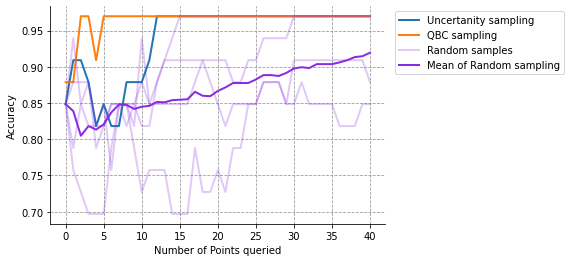

In [8]:
sampling_dict_class = {
    "Uncertanity": {
        "model": clone(RandomForestClassifier(random_state=42)),
        "query_strat": margin_sampling,
        "score": [],
        "marker": None,
        "type": "uncertanity",
    },
    "QBC": {
        "model": committee_class_list,
        "query_strat": margin_sampling,
        "score": [],
        "marker": None,
        "type": "qbc",
    },
    "Random": {
        "model": clone(RandomForestClassifier(random_state=42)),
        "query_strat": alu.random_sampling,
        "score": [],
        "mean_score": [],
        "std_dev": [],
        "marker": None,
        "type": "random",
        "n_iter": 50,
        "disp_randoms": 4,
        "mode": "all_random",
    },
}

# Specify latexify options for accuracy plot
latexify_dict = {
    "fig_name": "uncertanity_sampling_classification",
    "legend_params": {"loc": "lower right", "fontsize": 5, "framealpha": 0.5},
    "latexify_parms": {"width_scale_factor": 2},
}

compare_sampling(
    sampling_dict_class,
    "Classification",
    n_queries=40,
    X_pool=X_pool,
    y_pool=y_pool,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    latexify_dict=latexify_dict,
)